<a href="https://colab.research.google.com/github/NishitRam/FinSecure-Nishit-Ram-/blob/main/MLlab(Nishit).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving loan_data.csv to loan_data.csv


Training model...

Overall AUC Score: 0.9076


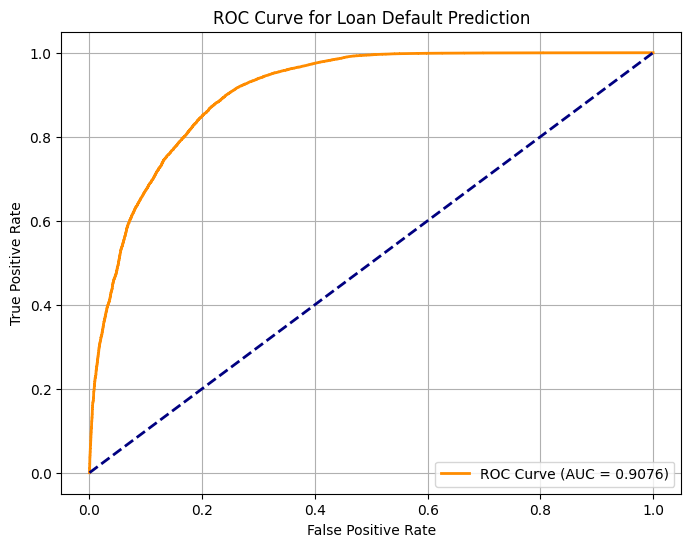


--- Subgroup Analysis: Education Level ---
Bachelor's: 0.9081
Master's: 0.9054
High School: 0.9062
PhD: 0.9044
Other: 0.9194

--- Subgroup Analysis: Loan Purpose ---

Top 3 Performing Loan Purposes:
Education: 0.9196
Vacation: 0.9126
Medical: 0.9126

Bottom 3 Performing Loan Purposes:
Business: 0.9076
Debt consolidation: 0.9064
Car: 0.8971


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve

# 1. Load Data
# Ensure 'loan_data.csv' is uploaded to your Colab environment
df = pd.read_csv('loan_data.csv')

# Drop ID column as it's not a feature
df = df.drop(columns=['id'])

# 2. Define Feature Groups
numeric_features = ['annual_income', 'debt_to_income_ratio', 'credit_score',
                    'loan_amount', 'interest_rate']
categorical_features = ['gender', 'marital_status', 'education_level',
                        'employment_status', 'loan_purpose', 'grade_subgrade']

X = df.drop(columns=['loan_paid_back'])
y = df['loan_paid_back']

# 3. Split Data (80% Train, 20% Test)
# Stratify ensures we maintain the same proportion of defaults in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

# Keep a copy of original X_test for subgroup analysis later
X_test_original = X_test.copy()

# 4. Create Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 5. Define Model (Random Forest)
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=10,
                                          random_state=42, n_jobs=-1))
])

# 6. Train Model
print("Training model...")
clf.fit(X_train, y_train)

# 7. Evaluate Performance
y_pred_proba = clf.predict_proba(X_test)[:, 1]
overall_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nOverall AUC Score: {overall_auc:.4f}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {overall_auc:.4f})', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Loan Default Prediction')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 8. Subgroup Analysis Function
def calculate_subgroup_auc(group_col):
    groups = X_test_original[group_col].unique()
    scores = {}
    for group in groups:
        mask = X_test_original[group_col] == group
        if mask.sum() > 0 and len(y_test[mask].unique()) > 1:
            score = roc_auc_score(y_test[mask], y_pred_proba[mask])
            scores[group] = score
    return scores

# Analyze by Education Level
print("\n--- Subgroup Analysis: Education Level ---")
edu_scores = calculate_subgroup_auc('education_level')
for level, score in edu_scores.items():
    print(f"{level}: {score:.4f}")

# Analyze by Loan Purpose
print("\n--- Subgroup Analysis: Loan Purpose ---")
purpose_scores = calculate_subgroup_auc('loan_purpose')
sorted_purposes = sorted(purpose_scores.items(), key=lambda x: x[1], reverse=True)

print("\nTop 3 Performing Loan Purposes:")
for p, s in sorted_purposes[:3]:
    print(f"{p}: {s:.4f}")

print("\nBottom 3 Performing Loan Purposes:")
for p, s in sorted_purposes[-3:]:
    print(f"{p}: {s:.4f}")